In [5]:
import sys
sys.path.append('../')

import numpy as np
import torch
import matplotlib

from user_funn.field import D1Field
from user_funn.get_net import ForwardNetwork
from user_funn.ds import get_data_loader
from user_funn.solver import CloudPointSolver
from user_funn.pde import grad

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ForwardNetwork([1, 50, 50, 50, 1]).to(device)
loss_fn = torch.nn.MSELoss()

# 定义损失函数
def pde_loss(model, data):
    x_in,y_real = data
    x_in.requires_grad=True
    U = model(x_in)
    u = U[:,[0]]
    dudx = grad(u, x_in)[0]
    loss = dudx + torch.pi * torch.sin(torch.pi * x_in)
    loss = loss_fn(loss, y_real)
    return loss

from user_funn.bc import data_loss_factory
data_loss = data_loss_factory(loss_fn,[0])

pde_epoch_size = 32
pde_batch_num = 1
pde_batch_size = pde_epoch_size//pde_batch_num

bc_epoch_size = 1
bc_batch_num = 1
bc_batch_size = bc_epoch_size//bc_batch_num

T_iter = 3
epoch_per_iter = 300

solver_list = []

# 初始化：迭代过程中使用的数据
pde_input_list = [None for i in range(T_iter)]
pde_output_list = [None for i in range(T_iter)]
bc_input_list = [None for i in range(T_iter)]
bc_output_list = [None for i in range(T_iter)]
last_flame_data_list = [None for i in range(T_iter)]
 
# INIT:BEGIN
# aim1:pde_input_list,pde_output_list,bc_input_list 不会因train改变，在本段中生成
# aim2:网络建立
# bc_output_list 在train时生成
for T_id in range(T_iter):
    t_span_start = 2*T_id
    t_span_end = 2*T_id+2 + 0.2

    pde_input_list[T_id] = \
        D1Field([t_span_start, t_span_end]).get_field_rand(pde_epoch_size)
    pde_output_list[T_id] = np.zeros([pde_epoch_size,1])
    bc_input_list[T_id] = np.array([[t_span_start]])

    solver_list.append(CloudPointSolver(
        model = [1, 100, 100, 100, 1],
        optimizer = "adam"))
# INIT:END

# TRAIN:BEGIN
epoch_num = T_iter * epoch_per_iter
for T_id in range(T_iter):
    print(f'current start:{T_id}')
    for i in range(epoch_per_iter):
        for use_model_id in range(T_iter):
            t_span_start = 2*use_model_id
            t_span_end = 2*use_model_id+2 +0.2
            # 模型信息交换周期
            if i%10 == 0:
                last_flame_data_list[use_model_id] = \
                    np.array(solver_list[use_model_id].model_eval([[t_span_start + 2]]))
                if use_model_id == 0:
                    bc_output_list[use_model_id] = np.zeros([bc_epoch_size ,1]) + 1
                else:
                    bc_output_list[use_model_id] = last_flame_data_list[use_model_id-1].reshape([bc_epoch_size ,1])

            # 测试周期
            if i%100 == 0:
                print(f'model{use_model_id}',end = '')
                solver_list[use_model_id].test_step(
                    cloud_point_list =[[pde_input_list[use_model_id],pde_output_list[use_model_id]],
                        [bc_input_list[use_model_id], bc_output_list[use_model_id]]],
                    loss_list = [pde_loss,data_loss],
                    batchsize = [pde_batch_size,bc_batch_size],
                    loss_weight_list = [1,1],
                    print_flag=True)

            # 网络训练
            solver_list[use_model_id].train_step(
                cloud_point_list =[[pde_input_list[use_model_id],pde_output_list[use_model_id]],
                    [bc_input_list[use_model_id], bc_output_list[use_model_id]]],
                loss_list = [pde_loss,data_loss],
                batchsize = [pde_batch_size,bc_batch_size],
                loss_weight_list = [1,1])
# TRAIN:END


current start:0
model0loss is [3.6877556  0.73156637 4.419322  ]
model1loss is [4.0167556  0.00667852 4.023434  ]
model2loss is [5.5925446e+00 2.6399372e-04 5.5928087e+00]
model0loss is [1.7687957e-01 8.9518144e-05 1.7696908e-01]
model1loss is [0.4106826  0.00582095 0.41650355]
model2loss is [2.7456646  0.00859915 2.7542636 ]
model0loss is [3.6127295e-03 8.1759054e-06 3.6209053e-03]
model1loss is [0.02067862 0.00012486 0.02080349]
model2loss is [2.6992073e+00 1.8938436e-04 2.6993966e+00]
current start:1
model0loss is [5.4613961e-04 1.2056847e-06 5.4734532e-04]
model1loss is [1.3684755e-02 1.4739874e-05 1.3699495e-02]
model2loss is [2.6161301e+00 2.5552823e-04 2.6163857e+00]
model0loss is [1.4574309e-04 1.2216537e-07 1.4586526e-04]
model1loss is [8.935569e-03 8.346536e-06 8.943915e-03]
model2loss is [2.4832170e+00 2.4094738e-04 2.4834580e+00]
model0loss is [7.1004899e-05 2.1429742e-08 7.1026327e-05]
model1loss is [3.0325088e-03 8.0509499e-06 3.0405598e-03]
model2loss is [2.0044363e+00 1

total error 0.019823831936823386
[[4.0167556e+00 6.6785165e-03 4.0234342e+00]
 [4.1068259e-01 5.8209547e-03 4.1650355e-01]
 [2.0678623e-02 1.2486280e-04 2.0803485e-02]
 [1.3684755e-02 1.4739874e-05 1.3699495e-02]
 [8.9355689e-03 8.3465357e-06 8.9439154e-03]
 [3.0325088e-03 8.0509499e-06 3.0405598e-03]
 [5.6389312e-04 2.3887201e-06 5.6628184e-04]
 [2.2876277e-04 5.0988689e-07 2.2927266e-04]
 [4.5277648e-02 1.5510812e-05 4.5293160e-02]]
[array([[0.99927014]], dtype=float32), array([[1.0056342]], dtype=float32), array([[1.012256]], dtype=float32)]


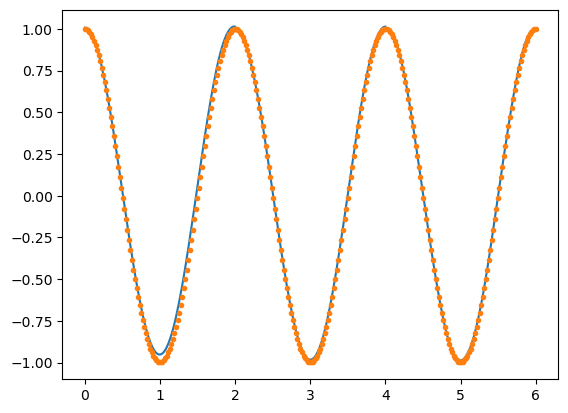

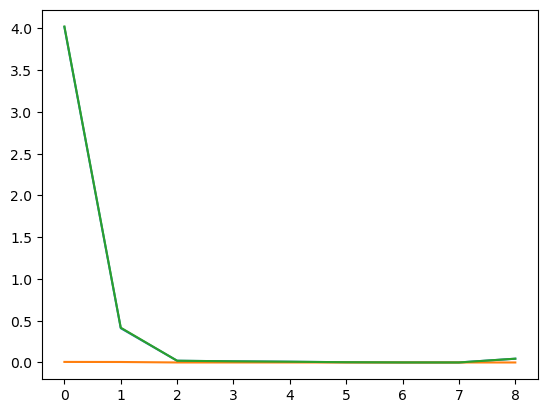

In [6]:

# EVAL:BEGIN
x_all = []
y_all = []
for T_id in range(T_iter):
    ## define a pde
    t_span_start = 2*T_id
    t_span_end = 2*T_id+2 +0.2

    x_cpu = np.linspace(t_span_start, t_span_start + 2, 100).reshape(100,1)
    y_cpu = solver_list[T_id].model_eval(x_cpu, use_best_model_flag = False)

    if T_id == 0:
        x_all = x_cpu
        y_all = y_cpu
    else:
        x_all = np.vstack([x_all,x_cpu])
        y_all = np.vstack([y_all,y_cpu])
# EVAL:END

import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(x_all,y_all)
y_all_real = np.cos(np.pi*np.array(x_all))
ax.plot(np.array(x_all), y_all_real,'.')
y_all_real = np.cos(np.pi*np.array(x_all))
print('total error', np.mean(np.abs(np.array(y_all_real)-np.array(y_all))) )
test_log = solver_list[1].get_logger()
test_log_np = np.array(test_log)

fig,ax = plt.subplots()
plt.plot(test_log_np[:,0])
plt.plot(test_log_np[:,1])
plt.plot(test_log_np[:,2])
print(test_log_np)

print(last_flame_data_list)